In [1]:
# All necessary imports. Some may be redundant
import os
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
from PIL import Image
# Progress Bards
from tqdm.notebook import tqdm

# Visualization libraries
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# If run locally, set up GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **EDA**

### Dataset Context



 - The dataset is the Ocular Disease Intelligent Recognition (ODIR) dataset composed of 5,000 patients. Included as features in this dataset are age, color fundus photographs from left and right eyes, and doctors' diagnostic keywords.

 - The dataset is collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. The fundus images themselves are captured by various cameras  including Canon, Zeiss and Kowa, resulting into various image resolutions.

 - Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:
    - Normal (N)
    - Diabetes (D)
    - Glaucoma (G)
    - Cataract (C)
    - Age related Macular Degeneration (A)
    - Hypertension (H)
    - Pathological Myopia (M)
    - Other diseases/abnormalities (O)

In [2]:
sns.set(style="whitegrid")

 - The dataset for this particular instance of the Jupyter notebook is saved to the Google Drive of the Notebooks main account creator.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 - Load in our csv files and our separate preprocessed images

In [4]:
# file paths for saved data
drive_path = '/content/drive/MyDrive/Capstone_Final/Ocular_Disease_Folder'
csv_file = os.path.join(drive_path, 'full_df.csv')
img_dir = os.path.join(drive_path, 'preprocessed_images')

In [5]:
# Reading in full_df.csv data, still need to manage img data
df = pd.read_csv(csv_file)
print("Columns in CSV:", df.columns.tolist())

Columns in CSV: ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename']


In [6]:
df.shape

(6392, 19)

 - Interestingly there are 19 different features within the dataset. This includes the two images for left and right eyes per patient, two different sets of diagnostic keywords for both left and right eyes per patient, our eight different diseases, labels, targets, and associated images for which the labels/targets are determined per row.

In [7]:
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

 - We can note that most data is as an integer type, with a few reflecting textual data being of object types. We may need to abstract numerical data to string, or more reliably, represent and encode string data into numerical values.

In [9]:
df.isnull().sum()

,0
ID,0
Patient Age,0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,0
D,0
G,0


 - There are no empty values within the non-image related features

In [10]:
print("\Summary Statistics")
df.describe()

\Summary Statistics


,ID,Patient Age,N,D,G,C,A,H,M,O
count,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000,6392.000000
mean,2271.150814,57.857947,0.328692,0.332134,0.062109,0.062891,0.049906,0.031758,0.047872,0.248436
std,1417.559018,11.727737,0.469775,0.471016,0.241372,0.242786,0.217768,0.175370,0.213513,0.432139
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,920.750000,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2419.500000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3294.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4784.000000,91.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


 - Interestingly, we can glance a few insights from the following statistics. Namely:
    - "G", "C", "A", "H", and "M" all have lower mean values than "N", "D", and "O". Given that these features are all binary (of 0 or 1 values, with 0 indicating the absence of the specified disease, and 1 the presence of the disease) we can surmise that there is a lower rate of positive instances of "G", "C", "A", "H", and "M". This may indicate a class imbalance among the categorized diseases.

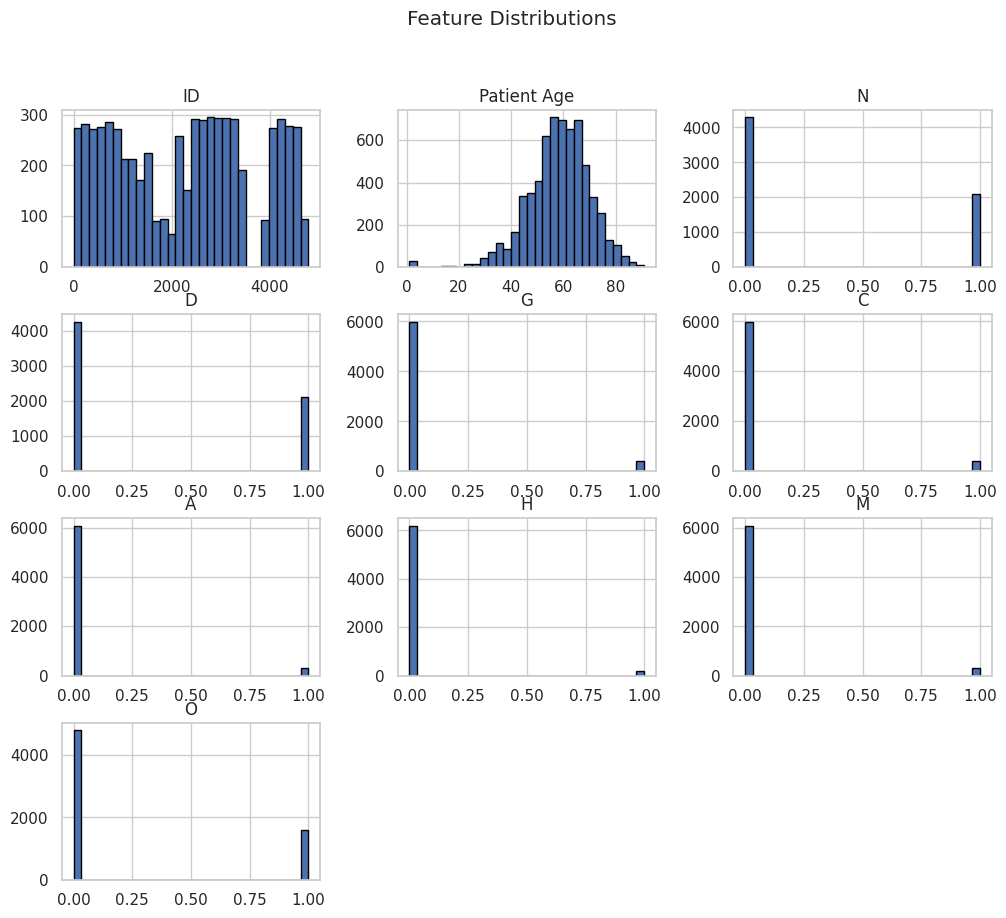

In [11]:
# Visualizing numerical feature distributions
df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

### Analysis of the Histogram Plots




1. ID Column
  *   The ID column is unique for each patient and does not contribute meaningful information
2. Patient Age
  * The distribution of Patient Age appears to be approximately normal, centered around middle-aged individuals (40-60 years old)
3. Binary Features (Columns: A, C, D, G, H, M, N, O)
  * As insinuated above, these binary features are highly imbalanced, where almost all values are 0, and only a few samples have 1
  * Given the various total counts for 1 among the dataset, it indicates that certain conditions are rare in the dataset, which will require data balancing techniques

### Key Takeaways



- ID should be removed from the model in preprocesing as it holds no value or relevancy
- Binary features are majority "0" value and deeply imbalanced across all classes. We will need to address and handle class imbalance for robust and generalized performance.

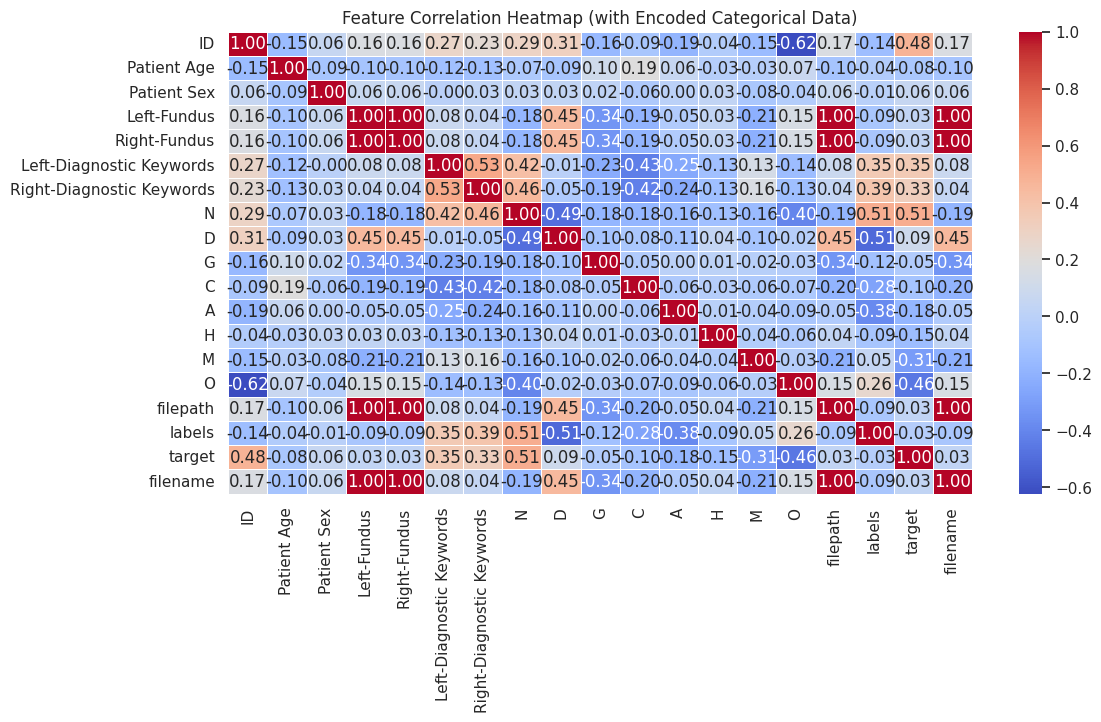

In [12]:
# Convert categorical columns to numerical with label encoding
df_encoded = df.copy()
label_encoders = {}

for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Correlation matrix of data
plt.figure(figsize=(12, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap (with Encoded Categorical Data)")
plt.show()

### Correlation Heatmap Analysis


- ID has no meaningful correlation and should be removed from our dataset

 - Few features have a relatively strong correlation with each other, although notably diagnostic features "N" and "D" are strongly correlated with each other, as well as "Labels" and "Target" with "N" and "D"

 - None are highly correlated enough to satisfy concerns of colinearity, and are all useful as we choose.

# **Preprocessing/Data Cleaning**

 - Given the foundation we've explored, we can now clean, modify, and extract relevant features on which to feed our model

 - With the amount of features present, we can narrow every row/instance down to be dependent on the independent filename associated with the target label present as a "1" value among the diseases. As a result, this reduces the mulitple features oriented as left/right among each individual patient.

In [13]:
# Set the filename feature as our ImageFiler reference
# Also setting the labels feature as the predicted ground truth label
df["ImageFile"] = df["filename"].apply(lambda x: x.strip() if isinstance(x, str) else None)
df["PredictedLabel"] = df["labels"].apply(lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else None)

# Rename and setup the Right, Left eye images and diagnostic keywords
df["RightFundus"] = df["Right-Fundus"].apply(lambda x: x.strip() if isinstance(x, str) else None)
df["LeftFundus"] = df["Left-Fundus"].apply(lambda x: x.strip() if isinstance(x, str) else None)
df["RightDiagnostic"] = df["Right-Diagnostic Keywords"].apply(lambda x: x.strip() if isinstance(x, str) else None)
df["LeftDiagnostic"] = df["Left-Diagnostic Keywords"].apply(lambda x: x.strip() if isinstance(x, str) else None)

# Diagnostic Keywords assigned to our ImageFile feature based on previous Right/Left Fundus features.
# This will make the Right/Left Fundus features irrelevant
def assign_diagnostic(row):
    if row["ImageFile"] == row["RightFundus"]:
        return row["RightDiagnostic"]
    elif row["ImageFile"] == row["LeftFundus"]:
        return row["LeftDiagnostic"]
    else:
        return None

df["DiagnosticKeywords"] = df.apply(assign_diagnostic, axis=1)
df.drop(columns=["Right-Fundus", "Left-Fundus"], inplace=True)

# Setting up patient demographics
df["PatientAge"] = pd.to_numeric(df["Patient Age"], errors='coerce')
df["PatientSexNumeric"] = df["Patient Sex"].map({"Male": 0, "Female": 1})

In [14]:
# We can now setup the final dataframe with all NEEDED features without excess
final_df = df[[
    "ImageFile",
    "PredictedLabel",
    "PatientAge",
    "PatientSexNumeric",
    "DiagnosticKeywords"
]].copy()

final_df.reset_index(drop=True, inplace=True)
print("Final DataFrame Sneak Peak")
print(final_df.head())

Final DataFrame Sneak Peak
     ImageFile PredictedLabel  PatientAge  PatientSexNumeric  \
0  0_right.jpg              N          69                  1   
1  1_right.jpg              N          57                  0   
2  2_right.jpg              D          42                  0   
3  4_right.jpg              D          53                  0   
4  5_right.jpg              D          50                  1   

                       DiagnosticKeywords  
0                           normal fundus  
1                           normal fundus  
2  moderate non proliferative retinopathy  
3       mild nonproliferative retinopathy  
4  moderate non proliferative retinopathy  


 - Now we have reduced the 8 different disease labels into a singular "PredictedLabel" representing the ground truth label associated with the "ImageFile" instance.

 - Further still, we've reduced redundant features such as "Target", "Labels", "FilePath", and "ID" into "ImageFile" and "PredictedLabel".

In [15]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ImageFile           6392 non-null   object
 1   PredictedLabel      6392 non-null   object
 2   PatientAge          6392 non-null   int64 
 3   PatientSexNumeric   6392 non-null   int64 
 4   DiagnosticKeywords  6392 non-null   object
dtypes: int64(2), object(3)
memory usage: 249.8+ KB


 - Our data is still a mixture of various data types representing numerical data and textual information as type object, which we will address later in the notebook

In [16]:
final_df.shape

(6392, 5)

In [17]:
final_df.head()

,ImageFile,PredictedLabel,PatientAge,PatientSexNumeric,DiagnosticKeywords
0,0_right.jpg,N,69,1,normal fundus
1,1_right.jpg,N,57,0,normal fundus
2,2_right.jpg,D,42,0,moderate non proliferative retinopathy
3,4_right.jpg,D,53,0,mild nonproliferative retinopathy
4,5_right.jpg,D,50,1,moderate non proliferative retinopathy


 - The dataframe "final_df" is nearly perfect, removing excessive features and consolidating all essential information into more manageable features.

 - Now we need to refine the final dataframe to be used in our multimodal neural network. We are working with a mix of image, text, and numerical data. A positive is that the numerical and image data are already in a great space. Given the changes to the diagnostic keywords, need to refine them a bit.

### Addressing Data Type Disparity

 - Addressing the aforementioned datatype issue, we convert the keywords which offer context to our diagnosis as found in "PatientAge" and "DiagnosticKeywords" into vector representations via TF-IDF and concatenate with the already converted "PatientSexNumeric" to represent a full, singular metadata vector.

In [18]:
# Fill in any missing diagnostic keywords with empty string as to not effect model unnecessarily
diagnostic_text = final_df["DiagnosticKeywords"].fillna("")

# Vectorize textual data with TF–IDF and limit it to 20 features which is already excessive
vectorizer = TfidfVectorizer(max_features=20)
diagnostic_tfidf = vectorizer.fit_transform(diagnostic_text).toarray()  # shape: (n_samples, 20)

In [19]:
# Preprocess the demographic data
# For patient age, we set the missing values to the mean and reshape to (X, 1)
age_array = final_df["PatientAge"].fillna(final_df["PatientAge"].mean()).values.reshape(-1, 1)
# For patient sex, we fill in missing values with 0 and reshape to (X, 1)
sex_array = final_df["PatientSexNumeric"].fillna(0).values.reshape(-1, 1)

# Concatenate togehter age, sex, and diagnostic TF–IDF vectors (20 features + 1 age + 1 sex = 22)
metadata_array = np.concatenate([age_array, sex_array, diagnostic_tfidf], axis=1)
print("Metadata vector shape:", metadata_array.shape)

# Add a metadata vector as a new column in final_df so that each instance has a list fo concatenated info
final_df["Metadata"] = [metadata_array[i].tolist() for i in range(metadata_array.shape[0])]
print("Instance metadata vector: ", final_df["Metadata"].iloc[0])

Metadata vector shape: (6392, 22)
Instance metadata vector:  [69.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7069700856180804, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7072434503345819, 0.0, 0.0, 0.0, 0.0]


 - With the data in appropriate format, we next address the heavily skewed imbalances between our diseases. The data on hand is severely imbalanced, the largest disparity between Normal (N) diagnosis and Hypertension (H) diagnosis. N is 22 times larger than H.

 - Previous attempts at balancing included adding weight penalties to respective classes to more severly punish the model for poor guesses on smaller sized labels or upsampling to total amount of "C" label while downsampling other excessive labels to that respective amount. Both methods yielded mediocre results as small manipulations with weights in such a deep model would result in large differences, and resampling smaller labels to class "C" size would cause the model to overfit on underrepresented classes.

 - In the end, after multiple attempts, we decided that a deep neural network with a complex architecture and plenty training techniques designed to prevent overfitting (L2 regularization, batch training, dropout, etc.) would be better on a smaller sized yet equally balanced dataset than other approaches.

 - As such, we set the dataset equal to the smallest sum of instances present of any labels, that being "H" at 128 total instances. The resultant model is sufficient to train on the few remaining labels, with the benefit of equally represented classes.

Total Count of Images Per Label:
PredictedLabel
A     266
C     293
D    1608
G     284
H     128
M     232
N    2873
O     708


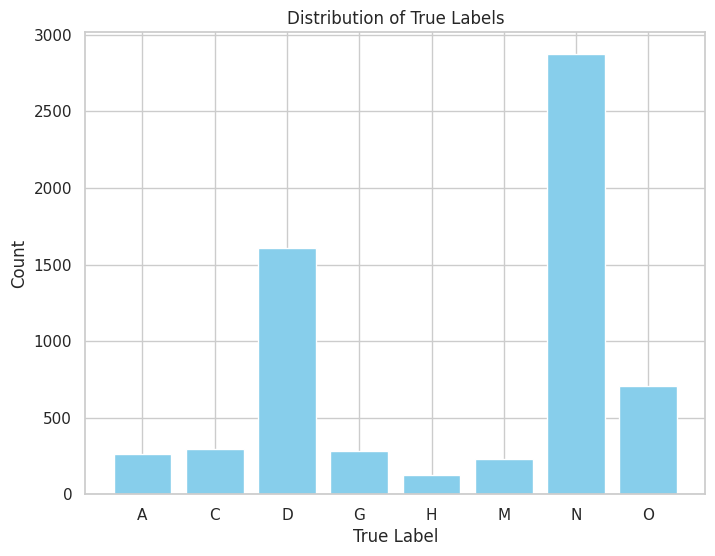

In [20]:
# First exploration of image class balance
label_counts = final_df['PredictedLabel'].value_counts().sort_index()
print("Total Count of Images Per Label:")
print(label_counts.to_string())

# Visualization of our class balance
plt.figure(figsize=(8,6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xlabel("True Label")
plt.ylabel("Count")
plt.title("Distribution of True Labels")
plt.show()

Target count for each class: 128


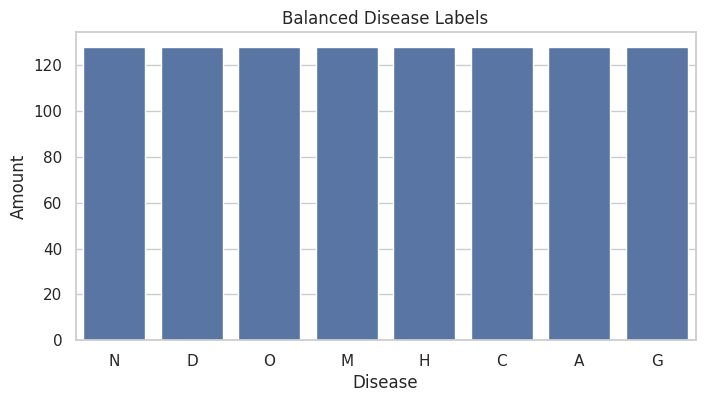

Balanced dataframe shape: (1024, 6)
Balanced label distribution:
PredictedLabel
N    128
D    128
O    128
M    128
H    128
C    128
A    128
G    128
Name: count, dtype: int64


In [21]:
# Set our target count to 'H' at 128 instances
target_count = 128
print("Target count for each class:", target_count)

resampled_dfs = []
# Loop over each label in PredictedLabel feature
for label in final_df['PredictedLabel'].unique():
    # All instances of the label
    group = final_df[final_df['PredictedLabel'] == label]
    # If the group has fewer than our target count, sample with replacement. Otherwise, sample w/o replacement.
    resampled_group = group.sample(n=target_count, random_state=39, replace=(len(group) < target_count))
    resampled_dfs.append(resampled_group)

# Concatenate all resampled groups to a new dataframe
balanced_df = pd.concat(resampled_dfs).reset_index(drop=True)
# Visualize and double check they are equal
plt.figure(figsize=(8, 4))
sns.countplot(data=balanced_df, x="PredictedLabel", order=balanced_df["PredictedLabel"].value_counts().index)
plt.title("Balanced Disease Labels")
plt.xlabel("Disease")
plt.ylabel("Amount")
plt.show()

print("Balanced dataframe shape:", balanced_df.shape)
print("Balanced label distribution:")
print(balanced_df['PredictedLabel'].value_counts())

# Reassign our dataframe to the balanced dataset
final_df = balanced_df.copy()

 - Now, with our dataset balanced and all necessary features present, we can lastly encode the "PredictedLabel" representing our ground truth disease associated with the image to a numerical value.

 - We can subsequently set the final iteration of our dataset to return an image, encoded label, and metadata vector per image per instance.

In [22]:
# Create label mapping from unique labels and convert to a numerical value
unique_labels = sorted(final_df["PredictedLabel"].dropna().unique())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
print("Label mapping:", label_mapping)

# Utilized classes for modularity to change adn experiment
# Setup for multimodal input
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, label_mapping=None):
        # DataFrame
        self.data = dataframe.reset_index(drop=True)
        # Pathway to preprocessed images in Google Drive
        self.img_dir = img_dir
        # Preprocessing transformations of images
        self.transform = transform
        # Dictionary mapping label strings to number values
        self.label_mapping = label_mapping

    def __len__(self):
        # Returns number of total samples in dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Loads in the row corresponding to our index
        row = self.data.iloc[idx]
        # Loads in the image file from path
        img_path = os.path.join(self.img_dir, row["ImageFile"])
        # Opens image and converts to RGB color grade
        img = Image.open(img_path).convert("RGB")
        # Experimented with transformations, this applies transformations should we use them
        if self.transform:
            img = self.transform(img)
        # Converts label to number
        label = row["PredictedLabel"]
        numeric_label = self.label_mapping.get(label, -1)
        # Converts our metadata vector (list type) to a float type tensor
        metadata = torch.tensor(row["Metadata"], dtype=torch.float)
        return img, numeric_label, metadata


Label mapping: {'A': 0, 'C': 1, 'D': 2, 'G': 3, 'H': 4, 'M': 5, 'N': 6, 'O': 7}


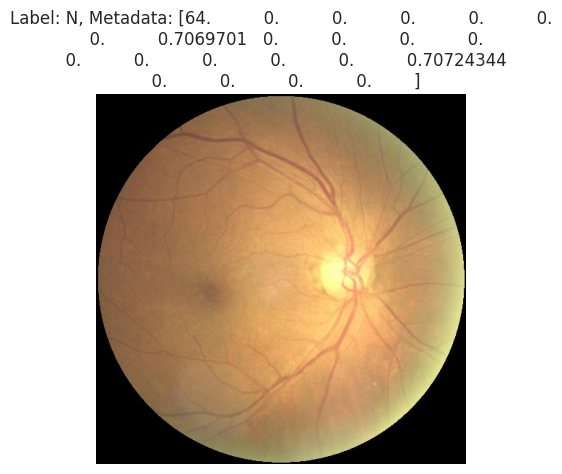

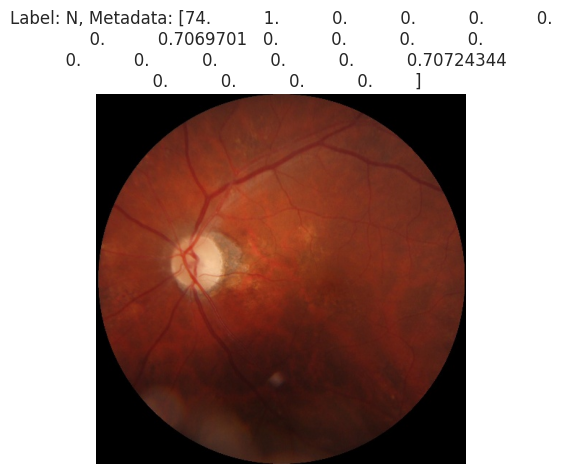

In [23]:
sample_dataset = MultiModalDataset(final_df, img_dir, transform=transforms.ToTensor(), label_mapping=label_mapping)
for i in range(2):
    img, lbl, meta = sample_dataset[i]
    plt.figure()
    plt.imshow(np.transpose(img.numpy(), (1,2,0)))
    plt.title(f"Label: {final_df['PredictedLabel'].iloc[i]}, Metadata: {meta.numpy()}")
    plt.axis("off")
    plt.show()

### Handling Image Data

  - As we mentioned above, the images present were collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China using various cameras and subsequently various image resolutions.

  - Outside of the various image resolutions, all images are already preprocessed to 512 x 512 pixels containing the fundus itself with blacked out surroundings. There is little to no noise to the images, and do not have any errors to them outside of the different resolutions.

  - Given everything, we will transform the image data to introduce some variability with some data augmentation so that after training, our model can better generalize on real world data. Furthermore, after transforming the images to tensors, we will normalize the resulting values.

In [24]:
# Simple dataset with express purpose of loading images to convert to tensors
# Converts images to tensors with pixel values in [0, 1] range
simple_transform = transforms.ToTensor()

class SimpleImageDataset(Dataset):
    def __init__(self, df, image_directory, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_directory = image_directory
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_directory, row["ImageFile"])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
# **NOTE: CHATGPT USED HERE FOR FUNCTIONS, did NOT find sufficient resources to calculate out
# Personal calculations were tremendously off**
norm_dataset = SimpleImageDataset(final_df, img_dir, transform=simple_transform)
norm_loader = DataLoader(norm_dataset, batch_size=16, shuffle=False, num_workers=4)

# Initializes accumulators for both sum, squared sum per channel
# Creates a counter for total images
channel_sum = torch.zeros(3)
channel_sq_sum = torch.zeros(3)
num_images = 0

# Iterates through the dataset and calculates statistics
for images in norm_loader:
    batch_size, channels, height, width = images.size()
    num_images += batch_size
    # Reshape images to (batch, channels, height*width)
    images = images.view(batch_size, channels, -1)
    # Sum the mean of each channel per image
    channel_sum += images.mean(dim=2).sum(dim=0)
    # Sum the standard deviation of each channel per image
    channel_sq_sum += images.std(dim=2).sum(dim=0)

# Compute the overall mean and standard deviation per channel
mean = channel_sum / num_images
std = channel_sq_sum / num_images

print("Calculated normalization mean:", mean)
print("Calculated normalization std:", std)
# CHATGPT CODE ENDS HERE

Calculated normalization mean: tensor([0.4468, 0.2905, 0.1625])
Calculated normalization std: tensor([0.2617, 0.1815, 0.1095])


In [25]:
train_transform = transforms.Compose([
    # Randomly flip an image
    transforms.RandomHorizontalFlip(),
    # Randomly rotate it 55 degs
    transforms.RandomRotation(55),
    # Randomly change color properties
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    # Convert from PIL to PyTorch tensor
    transforms.ToTensor(),
    # Normalize tensor figures
    transforms.Normalize(mean=[0.4468, 0.2905, 0.1625], std=[0.2617, 0.1815, 0.1095])
])

val_transform = transforms.Compose([
    # Convert img to Pytorch Tensor
    transforms.ToTensor(),
    # Normalize tensor figures
    transforms.Normalize(mean=[0.4468, 0.2905, 0.1625], std=[0.2617, 0.1815, 0.1095])
])


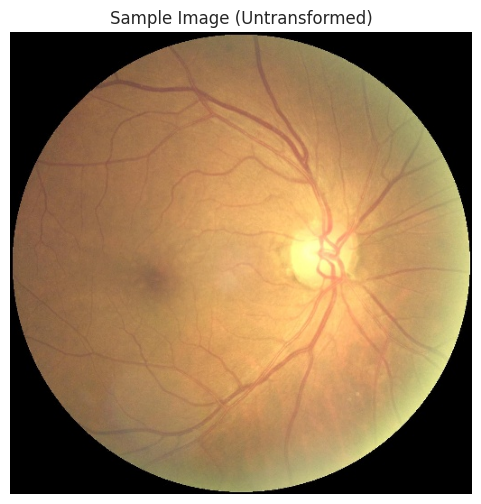

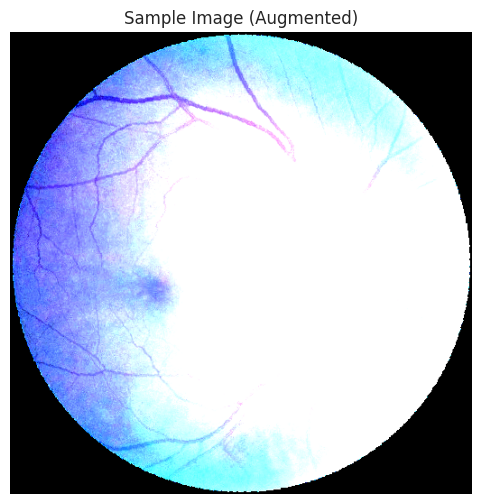

In [26]:
# Visualization of a training image with our applied augmentation
sample_img, _, _ = sample_dataset[0]
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(sample_img.numpy(), (1,2,0)))
plt.title("Sample Image (Untransformed)")
plt.axis("off")
plt.show()

# Visualization with an applied train_transform on the image
augmented_img = train_transform(Image.open(os.path.join(img_dir, final_df["ImageFile"].iloc[0])).convert("RGB"))
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(augmented_img.numpy(), (1,2,0)))
plt.title("Sample Image (Augmented)")
plt.axis("off")
plt.show()

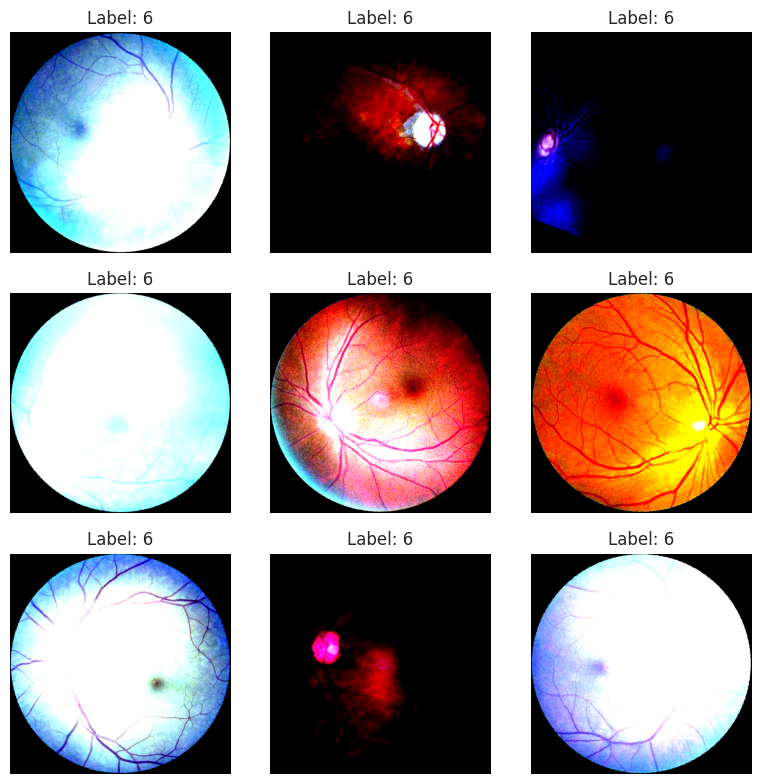

In [27]:
# A grid of training images visualized to see what we are working with
def training_img(dataset, num_images=9):
    plt.figure(figsize=(8,8))
    for i in range(num_images):
        img, lbl, meta = dataset[i]
        plt.subplot(3, 3, i+1)
        plt.imshow(np.transpose(img.numpy(), (1,2,0)))
        plt.title(f"Label: {lbl}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show all images
training_img(MultiModalDataset(final_df, img_dir, transform=train_transform, label_mapping=label_mapping))


# Model Design/Building

 - Our initial attempts conceptually followed Gulshan V. et al (2016) in developing and validating a CNN model on a purely image-based approach with associated labels but no metadata. These CNN models yielded 47% accuracy in diagnosing the presence of a disease in fundus images, without any attempts in labeling the type of disease from 8 possible options. Additional hyperparameter tuning and increased depth and width of the model returned 55%, 39% precision, and a F1 Score of 36%.

 - Many approaches online utilize a ResNet32 or VGG36 model. Avoiding any pre-trained models, we instead emulated the structure of a ResNet model trained on additional metadata such as diagnostic keywords and patient age/sex to improve our diagnostic capabilities.

 - Given our two types of data (metadata and images) we implemented a multimodal model composed of a ResNet inspired CNN for images and a MLP to process the metadata.

 - To seamlessly structure our model, we utilize O.O.P. to create classes and modularly build our model. Important elements of the model include:

    - BasicBlock_CBAM: A residual block with convolutional attention mechanisms computing both channel and spatial attention maps to reweight feature maps.
    - ASPP: Diales convolutions at multiple scales to capture context.
    - ResNetModel: Stacks multiple residual blocks with ASPP and CBAM to generate a 128 dimension feature from our 512 x 512 images.
    - MLP: Generates a 32 dimensional representation of our metadata.
    - MultiModalFull: Integrates the 32 dimensional and 128 dimensional results into a final classification layer for results.

In [28]:
# NN is based on a residual block with convolutional block attention module mechanisms
# In general, heightens feature representation and abstraction for model to better grasp underlying patterns
# Between features present in images and their respective labels
class BasicBlock_CBAM(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, dropout_rate=0.1):
        super(BasicBlock_CBAM, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # Attention mechanism is here
        self.cbam = CBAM(planes, reduction=16, kernel_size=7)
        self.dropout = nn.Dropout(dropout_rate)
        # A shortcut connection for residual learning
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        # Attention mechanism is applied to blocks output
        out = self.cbam(out)
        # Residual connection here
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CBAM (Convolutional Block Attention Module) for spatial and channel attention refining feature maps
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        # Avg and max pooling w/ MLP
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid_channel = nn.Sigmoid()
        # Aptial attention
        # Convolution layer over concatenated avg with max pooled features
        self.conv_after_concat = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        # Channel attention
        avg_out = self.mlp(self.avg_pool(x).view(b, c))
        max_out = self.mlp(self.max_pool(x).view(b, c))
        channel_att = self.sigmoid_channel(avg_out + max_out).view(b, c, 1, 1)
        x = x * channel_att
        # Spatial attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.conv_after_concat(torch.cat([avg_out, max_out], dim=1))
        spatial_att = self.sigmoid_spatial(spatial_att)
        x = x * spatial_att
        return x

# ASPP (Atrous Spatial Pyramid Pooling) for multi-scale feature extraction
# Extracts features at multiple different scales using dilated convolutions
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=6, dilation=6, bias=False)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=12, dilation=12, bias=False)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=18, dilation=18, bias=False)
        self.conv_1x1_output = nn.Conv2d(out_channels * 4, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)
        # Concatenate all features from all parallel convolutions
        x = torch.cat([x1, x2, x3, x4], dim=1)
        # Now reduce concatenated features using 1x1 convolution
        x = self.conv_1x1_output(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Resnet Model with CBAM and ASPP incorporated in it
# Given limited dataset and img complexity, this should be sufficient to extract image features
class ResNetModel(nn.Module):
    def __init__(self, block, num_blocks, num_classes=8, dropout_rate=0.1, width_factor=2):
        super(ResNetModel, self).__init__()
        self.width_factor = width_factor
        # After our first convolutional layer iteration, this should be the calculation for number of channels
        self.in_planes = 64 * width_factor
        # Setup and initialize first convolutional layer
        self.conv1 = nn.Conv2d(3, 64 * width_factor, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64 * width_factor)
        self.relu = nn.ReLU(inplace=True)
        # Max pooling for spatial dimension reduction
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Using [4, 6, 8, 6] blocks per layer, with increasing depth
        # Dropout every layer to prevent overfitting, extensive overfitting reduction techniques used throughout
        self.layer1 = self._make_layer(block, 64 * width_factor, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128 * width_factor, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256 * width_factor, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512 * width_factor, num_blocks[3], stride=2, dropout_rate=dropout_rate)

        # ASPP portion for multi scale feature extraction
        self.aspp = ASPP(512 * width_factor * block.expansion, 256 * width_factor)
        # Prefer global average pooling for fixed-size feature vector, was troublesome previously
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Heavy dropout before fully connected layer
        self.dropout_fc1 = nn.Dropout(0.5)
        # Fully connected layer
        # Creates image features which are 128 dimensional
        self.fc1 = nn.Linear(256 * width_factor, 128)
        self.dropout_fc2 = nn.Dropout(0.5)
        # Classification layer
        self.fc2 = nn.Linear(128, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, dropout_rate):
        # Creates a sequential layer made up of several blocks
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s, dropout_rate=dropout_rate))
            # Gotta update channel size after every block
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Standard forward pass for classification BUT not used directly in multi modal resnet
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.aspp(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_fc1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc2(x)
        x = self.fc2(x)
        return x

 - To understand and evaluate the scale of our model, we will create a fake "dummy" model to view all layers and trainable parameters.

In [29]:
false_model = ResNetModel(BasicBlock_CBAM, [4, 6, 8, 6], num_classes=len(unique_labels), dropout_rate=0.3, width_factor=2)
total_params = 0
print("\nTrainable parameters:")
for name, param in false_model.named_parameters():
    if param.requires_grad:
        param_count = param.numel()
        total_params += param_count
        print(f"{name:40s} | shape: {str(list(param.shape)):20s} | count: {param_count}")
print(f"\nTotal trainable parameters: {total_params}")



Trainable parameters:
conv1.weight                             | shape: [128, 3, 7, 7]       | count: 18816
bn1.weight                               | shape: [128]                | count: 128
bn1.bias                                 | shape: [128]                | count: 128
layer1.0.conv1.weight                    | shape: [128, 128, 3, 3]     | count: 147456
layer1.0.bn1.weight                      | shape: [128]                | count: 128
layer1.0.bn1.bias                        | shape: [128]                | count: 128
layer1.0.conv2.weight                    | shape: [128, 128, 3, 3]     | count: 147456
layer1.0.bn2.weight                      | shape: [128]                | count: 128
layer1.0.bn2.bias                        | shape: [128]                | count: 128
layer1.0.cbam.mlp.0.weight               | shape: [8, 128]             | count: 1024
layer1.0.cbam.mlp.2.weight               | shape: [128, 8]             | count: 1024
layer1.0.cbam.conv_after_concat.weight   | 

 - In the end, we pursued a deep and wide model resulting in 170,723,896 total trainable parameters in order to abstract usable results from our incredibly reduced dataset of 128 images per class.

 - Previous attempts of running our initial CNN model at approximately 10,000,000 parameters overloaded the available A100 Runtime instance (with available 40GB GPU). Considering the scale of this model, Mixed Precision Training and small batch sizing was implemented with eventual gradient scaling and tuned optimizer to reduce any computational load and increase training speed. The model still requires an A100 Runtime to train.

 - Below we fuse the image branch created with the ResNEtModel class with a small multi layer perceptron for metadata to form a 160 diemsnional vector passed through the final classifier (32 metadata feautures + 128 image features).

In [30]:
class MultiModalFull(nn.Module):
    def __init__(self, num_classes, width_factor=2, dropout_rate=0.3, metadata_dim=22):
        # For above arguments, num_classes is number of output classes (8 labels)
        # width_factor is scaling factor for CNN branch
        # Dropout_rate is slef explanatory
        # metadatadim is metadata vector dimensionality
        super(MultiModalFull, self).__init__()
        # Image branch using the ResNet, CBAM, ASPP
        self.image_extractor = ResNetModel(
            BasicBlock_CBAM, [4, 6, 8, 6], num_classes=num_classes,
            dropout_rate=dropout_rate, width_factor=width_factor
        )
        # small MLP to process metadata vector and output 128-dimensional feature vector.
        self.metadata_branch = nn.Sequential(
            # Maps input medata data dimensions to 64 features
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            # Reduces to 32 features
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Final classifier concatenates image features and metadata features
        # Image features is 128, metadata features is 32
        self.classifier = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, image, metadata):
        # Extract image features
        # Expected shape is (batch, 128)
        image_features = self.get_image_features(image)
        # Process metadata through MLP, expected shape is (batch, 32)
        metadata_features = self.metadata_branch(metadata)
        # Concatenate image and metadata features along feature dimension
        combined_features = torch.cat([image_features, metadata_features], dim=1)
        # Pass concatenated features through final classifier
        output = self.classifier(combined_features)
        return output

    def get_image_features(self, image):
        # Extract image features up to fc1 which *should* be 128
        x = self.image_extractor.relu(self.image_extractor.bn1(self.image_extractor.conv1(image)))
        x = self.image_extractor.maxpool(x)
        x = self.image_extractor.layer1(x)
        x = self.image_extractor.layer2(x)
        x = self.image_extractor.layer3(x)
        x = self.image_extractor.layer4(x)
        x = self.image_extractor.aspp(x)
        x = self.image_extractor.avgpool(x)
        # Flatten tensor
        x = x.view(x.size(0), -1)
        x = self.image_extractor.dropout_fc1(x)
        # Grab features from fc1 (fully connected layer 1) with ReLU activation
        image_features = F.relu(self.image_extractor.fc1(x))
        return image_features

# Test the multi-modal model with fake inputs to see if it works
# Batch size 2
fake_image = torch.randn(2, 3, 512, 512).to(device)
fake_metadata = torch.randn(2, 22).to(device)
multimodal_model = MultiModalFull(num_classes=len(unique_labels), width_factor=2, dropout_rate=0.3, metadata_dim=22).to(device)
fake_output = multimodal_model(fake_image, fake_metadata)
print("Testing output shape of MultiModalFull: ", fake_output.shape)


Testing output shape of MultiModalFull:  torch.Size([2, 8])


# **Model Training/Optimization**

 - With the ResNet and MLP model created and unified into the MultiModalFull class, we set up our training environment for testing. The data was split according to the standard 80%/20% for training and validation, with applied transformations and label mapping afterwards. Batch sizing was reduced to a maximum of 16 with shuffling enabled in case we need additional training across many epochs and beyond the available, immediate data available.  

In [31]:
# Split the balanced final_df into training and validation sets stratified by our prediction label
train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=39, stratify=final_df["PredictedLabel"])
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Create dataset instances with MultiModal dataset class
train_dataset = MultiModalDataset(train_df, img_dir, transform=train_transform, label_mapping=label_mapping)
val_dataset = MultiModalDataset(val_df, img_dir, transform=val_transform, label_mapping=label_mapping)

# Create DataLoaders to iterate over the datasets, imperative to lower batch size and shuffle training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

Training samples: 819, Validation samples: 205


### **Optimization of Parameters**

 - In general, there was a lot of required optimization to tune in the model. Initially with our CNN attempt, there was an issue of both exploding and vanishing gradients, one of the reasons we pursued a reflection of a ResNet architecture leveraging residual connections. Likewise, overfitting was a persistent issue, addressed through the regularization layers present across each class and additional 30% dropout rate across most layers.

 - Similarly, to address the gradient issue, we initially pursued Stochastic Gradient Descent (SGD) which, in addition to the above precautions, stiffled the learning process of our model while simultaneously prolonging training time. Instead, we utilized AdamW as our optimizer since there are plenty of measures taken to prevent overfitting. Decoupling the weighte decay from the learning rate in AdamW as opposed to coupling with a penalty between each update/epoch in SGD provided th enecessary control over regularization (and overfitting) and additional parameters (dropout between layers) without stiffling the learning rate. This enabled a quicker training rate and ramp up to training for our model.

 - Lastly, given the delicateness of the learning rate at various epochs in training, we implemented a OneCycleLR to utilize different learning rates to ensure more stability and future generalization. This worked well with AdamW because of the decoupling weight decay from the learning rate, giving more freedom to the model. We also used CrossEntropyLoss for modeling weight updates based on errors of the previous iteration of training.


In [32]:
# Was initially 150, now 30-60 with optimizer change
num_epochs = 30
learning_rate = 1e-3

# Trial tracking to see improvements
writer = SummaryWriter(log_dir="runs/trials")

# Model, optimizer, scheduler, loss function initializer
model = MultiModalFull(num_classes=len(unique_labels), width_factor=2, dropout_rate=0.3, metadata_dim=22).to(device)
# Initially with Stochastic Gradient Descent as management of exploding gradients in previous models
# Now, with other techniques managing the issue, AdamW is best
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = OneCycleLR(optimizer, max_lr=3e-3, steps_per_epoch=len(train_loader), epochs=num_epochs, anneal_strategy='cos', pct_start=0.1)
# Previously used focal loss, avoid
criterion = nn.CrossEntropyLoss()

# IMPORTANT: Set up mixed precision training scaler to have sufficient computational resources to run model
scaler = torch.amp.GradScaler(device='cuda')

best_val_loss = float("inf")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # Iterates over training data
    for imgs, labels, metadata in  tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
        # Moves data to specified device if running locally
        imgs = imgs.to(device)
        labels = labels.to(device)
        metadata = metadata.to(device)
        # Reset gradients for optimizer
        optimizer.zero_grad()
        # Forward pass w/ mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(imgs, metadata)
            loss = criterion(outputs, labels)
        # Backwards pass w/ gradient scaling
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        # Clipping gradients to prevent exploding gradients problem mentioned above
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        scaler.step(optimizer)
        scaler.update()
        # Updated lr scheduler
        scheduler.step()
        # Cumulative training loss
        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels, metadata in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            metadata = metadata.to(device)
            with torch.cuda.amp.autocast():
                outputs = model(imgs, metadata)
                loss = criterion(outputs, labels)
            running_val_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    writer.add_scalar("Train_Loss", train_loss, epoch)
    writer.add_scalar("Validation_Loss", val_loss, epoch)

    # Save best model if and only if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("Best model is now saved")

writer.close()

Epoch 1/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

<ipython-input-32-a68b96a5887c>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

<ipython-input-32-a68b96a5887c>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/30] - Train Loss: 2.0946, Val Loss: 3.3848
Best model is now saved


Epoch 2/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 2/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/30] - Train Loss: 2.0821, Val Loss: 2.0596
Best model is now saved


Epoch 3/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 3/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/30] - Train Loss: 2.0509, Val Loss: 2.1286


Epoch 4/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 4/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/30] - Train Loss: 2.0088, Val Loss: 1.9176
Best model is now saved


Epoch 5/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 5/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/30] - Train Loss: 1.7223, Val Loss: 1.2860
Best model is now saved


Epoch 6/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 6/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/30] - Train Loss: 1.2085, Val Loss: 0.7953
Best model is now saved


Epoch 7/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 7/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/30] - Train Loss: 0.9063, Val Loss: 0.6745
Best model is now saved


Epoch 8/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 8/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/30] - Train Loss: 0.7804, Val Loss: 0.4969
Best model is now saved


Epoch 9/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 9/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/30] - Train Loss: 0.6636, Val Loss: 0.3680
Best model is now saved


Epoch 10/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 10/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/30] - Train Loss: 0.5342, Val Loss: 0.3468
Best model is now saved


Epoch 11/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 11/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/30] - Train Loss: 0.4132, Val Loss: 0.2380
Best model is now saved


Epoch 12/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 12/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/30] - Train Loss: 0.3938, Val Loss: 0.1910
Best model is now saved


Epoch 13/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 13/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/30] - Train Loss: 0.3466, Val Loss: 0.1873
Best model is now saved


Epoch 14/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 14/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/30] - Train Loss: 0.2987, Val Loss: 0.1586
Best model is now saved


Epoch 15/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 15/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/30] - Train Loss: 0.3225, Val Loss: 0.1525
Best model is now saved


Epoch 16/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 16/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/30] - Train Loss: 0.2689, Val Loss: 0.1390
Best model is now saved


Epoch 17/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 17/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/30] - Train Loss: 0.2326, Val Loss: 0.1210
Best model is now saved


Epoch 18/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 18/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/30] - Train Loss: 0.2265, Val Loss: 0.1085
Best model is now saved


Epoch 19/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 19/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/30] - Train Loss: 0.2382, Val Loss: 0.1381


Epoch 20/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 20/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/30] - Train Loss: 0.1901, Val Loss: 0.1266


Epoch 21/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 21/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/30] - Train Loss: 0.2421, Val Loss: 0.1113


Epoch 22/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 22/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/30] - Train Loss: 0.1875, Val Loss: 0.1184


Epoch 23/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 23/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/30] - Train Loss: 0.1706, Val Loss: 0.1019
Best model is now saved


Epoch 24/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 24/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/30] - Train Loss: 0.2185, Val Loss: 0.1238


Epoch 25/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 25/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/30] - Train Loss: 0.1825, Val Loss: 0.1079


Epoch 26/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 26/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/30] - Train Loss: 0.1597, Val Loss: 0.1166


Epoch 27/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 27/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/30] - Train Loss: 0.1792, Val Loss: 0.1117


Epoch 28/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 28/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/30] - Train Loss: 0.1756, Val Loss: 0.1067


Epoch 29/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 29/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/30] - Train Loss: 0.1452, Val Loss: 0.1071


Epoch 30/30 - Training:   0%|          | 0/52 [00:00<?, ?it/s]

Epoch 30/30 - Validation:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/30] - Train Loss: 0.1821, Val Loss: 0.1071


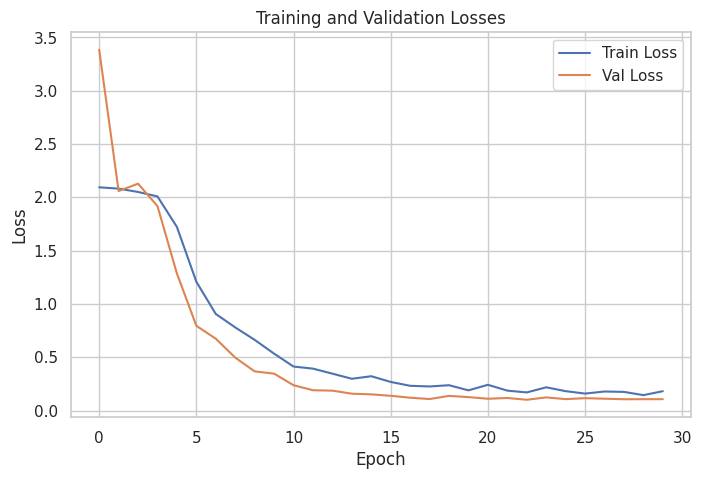

In [33]:
# Training, Validation curves
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()
plt.show()

# **Model Analysis**

 - As measured above in the training process, the model reduced the CrossEntropyLoss down to a training loss of 0.1452 and a validation loss of 0.1019 across 30 epochs and a total of approximately 6.5 minutes. However, both training and validation loss gather minimal gains after the 15th epoch.

In [34]:
# Load the best model for evaluation on the validation set
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Initialize lists for storing preds and ground truth labels
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels, metadata in tqdm(val_loader, desc="Testing", leave=False):
        imgs = imgs.to(device)
        labels = labels.to(device)
        metadata = metadata.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(imgs, metadata)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
report = classification_report(all_labels, all_preds, target_names=list(label_mapping.keys()))
print("Classification Report:")
print(report)

Testing:   0%|          | 0/13 [00:00<?, ?it/s]

<ipython-input-34-e2e971e17ec6>:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Classification Report:
              precision    recall  f1-score   support

           A       0.96      1.00      0.98        26
           C       1.00      0.96      0.98        26
           D       0.92      0.96      0.94        25
           G       0.96      1.00      0.98        25
           H       1.00      0.92      0.96        26
           M       1.00      1.00      1.00        25
           N       1.00      1.00      1.00        26
           O       0.96      0.96      0.96        26

    accuracy                           0.98       205
   macro avg       0.98      0.98      0.98       205
weighted avg       0.98      0.98      0.98       205



### Model Metrics

 - Measuring the accuracy, precision, recall, and F1 score of the model against reserved testing data, we returned incredible scores. Given the class balancing performed in our preprocessing section, we will focus on the macro average results.

    - **Precision**: Precision, or how many correct instances were actually correct, resulting in 98%, indicating a low false positive rate. In a medical environment as related to our dataset, This is highly valued as to appropriately diagnose a patient.

    - **Recall**: Measuring how many of the actual cases to a class the model correctly identified, a value of 98% indicates that there were a few identified false positives, but relatively minimal still

    - **F1-Score**: The balance between precision and recall, it measures the generalizing capability of our model. Returning a 99% value shows a very well maintained balance between our false positive rate and identifying false positives.

    - **Accuracy**: Our correct predictions relative to all true predictions, at 98%, it shows our model to accurately classify 98% of all instances across all diseases correctly

### Per Class Basis

 - On a per class performance basis, we can deduce further that:

    - **Label A (Age Related Macular Degeneration)**: (Precision = 0.96, Recall = 1.00, F1-Score = 0.98) while almost all predictions for an image being diagnosed with label A (Age Related Macular Degeneration) were correct (precision), the model identified all actual instances of label A (recall)

    - **Label C (Cataracts)**: (Precision = 1.00, Recall = 0.96, F1-Score = 0.98). while all predictions for an image being diagnosed with label C (Cataracts) were correct (precision), the model identified misidentified all actual instances of label C (recall). Still, it performed well.

    - **Label D (Diabetes)**: (Precision = 0.92, Recall = 0.96, F1-Score = 0.94). On instances of Diabetes,the model performed most poorly in correctly identifying actual images containing diabetes, and was likewise imprecise in identifying diabetes. It as well incorrectly identified a lot of fundus images as having diabetes where none was present. This was the poorest class on which our model performed.

    - **Label G (Glaucoma)**: (Precision = 0.96, Recall = 1.00, F1-Score = 0.98). Regarding glaucoma, nearly all images that had glaucoma were correctly identified, and likewise correctly identified all images presenting with glaucoma. Considering the poor results in Diabetes and the symptoms of both diseases, our model likely misidentified the presence of glaucoma in images with diabetes diagnosis.

    - **Label H (Hypertension)**: (Precision = 1.00, Recall = 0.92, F1-Score = 0.96). Similarly, there is perfect precision in every predicted instance of hypertension being correct, albeit at the expense of missing some instances of hypertension in other images. Considering the class imbalances, these results are promising and add weight to our data management techniques.

    - **Label M (Pathological Myopia)**: (Precision = 1.00, Recall = 1.00, F1-Score = 1.00). For this disease, we perfectly predicted and acccurately predicted all instances of pathological myopia.

    - **Label N (Normal)**: (Precision = 1.00, Recall = 1.00, F1-Score = 1.00). For these fundus photos, we perfectly predicted and acccurately predicted all instances of simply normal eyes.

    - **Label O (Other Diseases/Abnormalities)**: (Precision = 0.96, Recall = 0.96, F1-Score = 0.96). 96% across the board, there is a relatively high balance between predicting every occurance of abnormalities correctly and capturing all occurances of abnormalities.



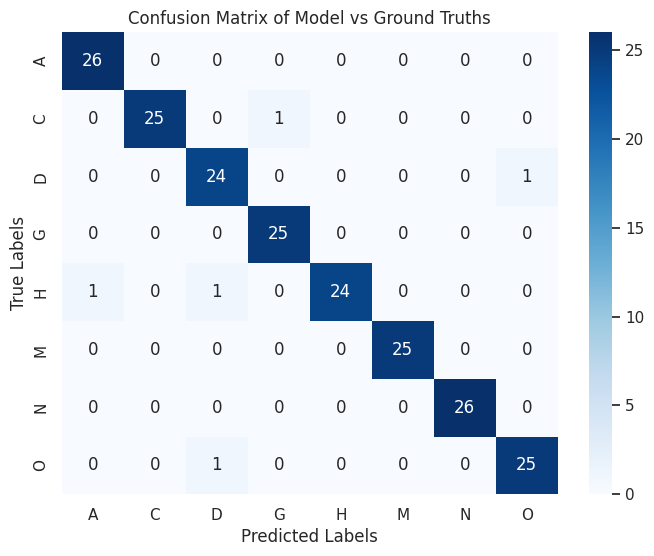

In [35]:
# Additional confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label_mapping.keys()),
            yticklabels=list(label_mapping.keys()))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Model vs Ground Truths")
plt.show()

### Final Conclusion

 - Given the relatively low testing amount, any poor prediction holds a more profound affect on our metrics. Viewing the confusion matrix, we can see that few predictions are misclassified, and a mistake in misclassifying one disease for another particular disease only occurs at most once. This bodes incredibly well for our model, and offers potential at furthering the project in a demonstrated pseudo-real-world application.

In [36]:
# Save the model!
torch.save(model.state_dict(), "best_model.pt")

# **References**

Andrew, M. V. D. Ocular Disease Recognition (ODIR-5K) (Data set). *Kaggle*. https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k

Chen, L.-C., Papandreou, G., Kokkinos, I., Murphy, K., & Yuille, A. L. (2016). DeepLab: Semantic image segmentation with deep convolutional nets, atrous convolution, and fully connected CRFs. *arXiv*. https://arxiv.org/abs/1606.00915v2

Fauw, D. et al. (2018). Clinically applicable deep learning for diagnosis and referral in retinal
disease. *Nature Medicine*, 24(9), 1342–1350.

Gulshan, V . et al. (2016). Development and validation of a deep learning algorithm for detection
of diabetic retinopathy in retinal fundus photographs. *JAMA*, 316(22), 2402–2410.

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. *IEEE Conference on Computer Vision and Pattern Recognition* (pp. 770–778).

IDx Technologies. (2018). IDx-DR: Autonomous AI-based diagnostic system for diabetic
retinopathy (Software). https://www.idxdr.com/

OpenAI. (2023). ChatGPT (Large language model). https://chat.openai.com/

TensorFlow. In TensorFlow API documentation. https://www.tensorflow.org/api_docs/python/tf/all_symbols

Ting, D. et al.(2017). Development and validation of a deep learning system for diabetic
retinopathy and related eye diseases using retinal images from multiethnic populations with
diabetes. *JAMA*, 318(22), 2211–2223.

Triveldi, S. (June 12th, 2020). Understanding attention modules: CBAM and BAM. *Medium*. https://medium.com/visionwizard/understanding-attention-modules-cbam-and-bam-a-quick-read-ca8678d1c671

Tsang, Sik-Ho. (November 19, 2018) Review: DeepLabV1, DeepLabV2, atrous convolution & semantic segmentation. *Medium*. https://medium.com/data-science/review-deeplabv1-deeplabv2-atrous-convolution-semantic-segmentation-b51c5fbde92d

Versloot, C. (n.d.) How to build a ResNet from scratch with TensorFlow 2 and Keras. *GitHub*. https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-build-a-resnet-from-scratch-with-tensorflow-2-and-keras.md

Woo, S., Park, J., Lee, J.-Y., & Kweon, I. S. (2018). CBAM: Convolutional Block Attention Module. *European Conference on Computer Vision* (ECCV) (pp. 3–19). Springer.

Zhongwen, L., Chen, W. (2023). *Solving Data Quality Issues of Fundus Images in Real-World Settings by Opthalmic AI*. https://pmc.ncbi.nlm.nih.gov/articles/PMC9975325/#:~:text=Ocular%20fundus%20diseases%2C%20such%20as,the%20living%20quality%20of%20patients.